In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np


/vol/csedu-nobackup/project/tromanski/conda-envs/code-search/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## General Stats 

In [2]:
# SST-2 (GLUE)
sst2 = load_dataset("glue", "sst2")

# IMDb
imdb = load_dataset("imdb")


Generating unsupervised split: 100%|██████████| 50000/50000 [00:01<00:00, 35279.38 examples/s]


In [3]:
sst2_train_size = len(sst2["train"])
sst2_val_size   = len(sst2["validation"])
sst2_test_size  = len(sst2["test"])

imdb_train_size = len(imdb["train"])
imdb_test_size  = len(imdb["test"])


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [5]:
def add_len_sst2(example):
    tokens = tokenizer(
        example["sentence"],
        truncation=False,
        add_special_tokens=True
    )
    example["seq_len"] = len(tokens["input_ids"])
    return example

sst2_with_len = sst2.map(add_len_sst2, batched=False)


Map: 100%|██████████| 1821/1821 [00:00<00:00, 3497.87 examples/s]


In [6]:
def length_stats(dataset, split):
    lengths = np.array(dataset[split]["seq_len"])
    return {
        "median": int(np.median(lengths)),
        "mean": float(np.mean(lengths)),
        "min": int(np.min(lengths)),
        "max": int(np.max(lengths)),
    }

sst2_train_stats = length_stats(sst2_with_len, "train")
sst2_val_stats   = length_stats(sst2_with_len, "validation")
sst2_test_stats  = length_stats(sst2_with_len, "test")


In [8]:
sst2_train_stats

{'median': 10, 'mean': 13.319262349849293, 'min': 3, 'max': 66}

In [9]:
sst2_val_stats

{'median': 24, 'mean': 25.163990825688074, 'min': 4, 'max': 55}

In [11]:
def add_len_imdb(example):
    tokens = tokenizer(
        example["text"],
        truncation=False,
        add_special_tokens=True
    )
    example["seq_len"] = len(tokens["input_ids"])
    return example

split = imdb["test"].train_test_split(test_size=0.5, seed=42, stratify_by_column="label")

imdb["validation"] = split["train"]   # becomes validation set
imdb["test"] = split["test"]          
imdb_with_len = imdb.map(add_len_imdb, batched=False)

imdb_train_stats = length_stats(imdb_with_len, "train")
imdb_test_stats  = length_stats(imdb_with_len, "validation")  # renamed to validation


Map: 100%|██████████| 12500/12500 [00:14<00:00, 841.08 examples/s]


In [10]:
imdb_train_stats

{'median': 233, 'mean': 313.87132, 'min': 13, 'max': 3127}

In [12]:
imdb_test_stats

{'median': 232, 'mean': 309.53296, 'min': 10, 'max': 3157}

# Top Tokens 

In [7]:
import os 
import json

In [5]:
os.chdir('/home/tromanski/thesis')

In [8]:
token_stats_file = 'results/sst2_bert_token_counts.json'
with open(token_stats_file, 'r') as f:
    token_stats = json.load(f)

In [9]:
pos_stats = token_stats['1']
neg_stats = token_stats['0']

POS counts: n=3573, mean=10.51, median=2, min=1, max=913
NEG counts: n=1654, mean=18.00, median=3, min=1, max=5892


/vol/csedu-nobackup/project/tromanski/tmp/ipykernel_1021336/4187882412.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box.set_xticklabels(['pos', 'neg'])


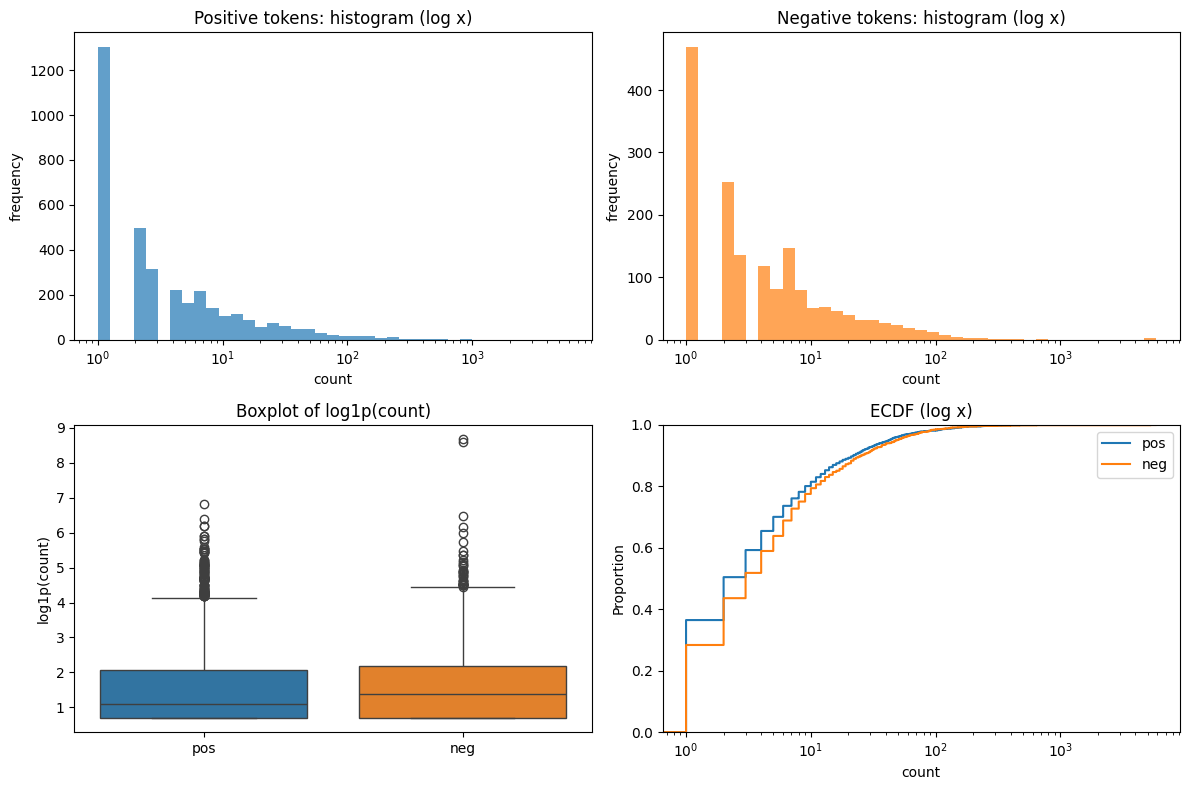

In [ ]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

def extract_counts(nested_stats):
    # sum inner dict counts to be robust (handles multiple tokens per id)
    return np.array([sum(inner.values()) for inner in nested_stats.values()], dtype=int)

pos_counts = extract_counts(pos_stats)
neg_counts = extract_counts(neg_stats)

# Print basic summary
print("POS counts: n={}, mean={:.2f}, median={}, min={}, max={}".format(
    len(pos_counts), pos_counts.mean(), int(np.median(pos_counts)), pos_counts.min(), pos_counts.max()))
print("NEG counts: n={}, mean={:.2f}, median={}, min={}, max={}".format(
    len(neg_counts), neg_counts.mean(), int(np.median(neg_counts)), neg_counts.min(), neg_counts.max()))

# Setup figure
fig, axes = plt.subplots(2, , figsize=(12, 8))
ax_hist_pos, ax_hist_neg, ax_box, ax_ecdf = axes.flatten()

# Log-spaced bins for heavy-tailed counts
max_count = max(pos_counts.max(), neg_counts.max())
bins = np.logspace(0, np.log10(max_count + 1), 40)

ax_hist_pos.hist(pos_counts, bins=bins, color='C0', alpha=0.7)
ax_hist_pos.set_xscale('log')
ax_hist_pos.set_title('Positive tokens: histogram (log x)')
ax_hist_pos.set_xlabel('count')
ax_hist_pos.set_ylabel('frequency')

ax_hist_neg.hist(neg_counts, bins=bins, color='C1', alpha=0.7)
ax_hist_neg.set_xscale('log')
ax_hist_neg.set_title('Negative tokens: histogram (log x)')
ax_hist_neg.set_xlabel('count')
ax_hist_neg.set_ylabel('frequency')

# Boxplot on log1p(count) to visualize center/spread
sns.boxplot(data=[np.log1p(pos_counts), np.log1p(neg_counts)], ax=ax_box)
ax_box.set_xticklabels(['pos', 'neg'])
ax_box.set_ylabel('log1p(count)')
ax_box.set_title('Boxplot of log1p(count)')

# ECDFs for full-distribution comparison (log x axis)
sns.ecdfplot(pos_counts, ax=ax_ecdf, label='pos', stat='proportion')
sns.ecdfplot(neg_counts, ax=ax_ecdf, label='neg', stat='proportion')
ax_ecdf.set_xscale('log')
ax_ecdf.set_xlabel('count')
ax_ecdf.set_title('ECDF (log x)')
ax_ecdf.legend()

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

def extract_counts(nested_stats):
    # sum inner dict counts to be robust (handles multiple tokens per id)
    return np.array([sum(inner.values()) for inner in nested_stats.values()], dtype=int)

pos_counts = extract_counts(pos_stats)
neg_counts = extract_counts(neg_stats)

# Print basic summary
print("POS counts: n={}, mean={:.2f}, median={}, min={}, max={}".format(
    len(pos_counts), pos_counts.mean(), int(np.median(pos_counts)), pos_counts.min(), pos_counts.max()))
print("NEG counts: n={}, mean={:.2f}, median={}, min={}, max={}".format(
    len(neg_counts), neg_counts.mean(), int(np.median(neg_counts)), neg_counts.min(), neg_counts.max()))

# Setup figure
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
ax_hist_pos, ax_hist_neg, ax_box, ax_ecdf = axes.flatten()

# Log-spaced bins for heavy-tailed counts
max_count = max(pos_counts.max(), neg_counts.max())
bins = np.logspace(0, np.log10(max_count + 1), 40)

ax_hist_pos.hist(pos_counts, bins=bins, color='C0', alpha=0.7)
ax_hist_pos.set_xscale('log')
ax_hist_pos.set_title('Positive tokens: histogram (log x)')
ax_hist_pos.set_xlabel('count')
ax_hist_pos.set_ylabel('frequency')

ax_hist_neg.hist(neg_counts, bins=bins, color='C1', alpha=0.7)
ax_hist_neg.set_xscale('log')
ax_hist_neg.set_title('Negative tokens: histogram (log x)')
ax_hist_neg.set_xlabel('count')
ax_hist_neg.set_ylabel('frequency')

# Boxplot on log1p(count) to visualize center/spread
sns.boxplot(data=[np.log1p(pos_counts), np.log1p(neg_counts)], ax=ax_box)
ax_box.set_xticklabels(['pos', 'neg'])
ax_box.set_ylabel('log1p(count)')
ax_box.set_title('Boxplot of log1p(count)')

# ECDFs for full-distribution comparison (log x axis)
sns.ecdfplot(pos_counts, ax=ax_ecdf, label='pos', stat='proportion')
sns.ecdfplot(neg_counts, ax=ax_ecdf, label='neg', stat='proportion')
ax_ecdf.set_xscale('log')
ax_ecdf.set_xlabel('count')
ax_ecdf.set_title('ECDF (log x)')
ax_ecdf.legend()

plt.tight_layout()
plt.show()

In [16]:
sorted(neg_counts, reverse=True)[:20]

[np.int64(5892),
 np.int64(5306),
 np.int64(644),
 np.int64(466),
 np.int64(396),
 np.int64(311),
 np.int64(235),
 np.int64(214),
 np.int64(212),
 np.int64(182),
 np.int64(171),
 np.int64(164),
 np.int64(160),
 np.int64(152),
 np.int64(137),
 np.int64(133),
 np.int64(131),
 np.int64(129),
 np.int64(128),
 np.int64(121)]